# PRACTICA 2

## 0. Importacion de Modulos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import re
import unicodedata
from difflib import SequenceMatcher


spanish_stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data Wrangling


Los datos se obtuvieron de un chat de WhatsApp, posteriormente se exportaron a un TXT.

In [ ]:
import re
import pandas as pd
from datetime import datetime

RUTA_ARCHIVO = "/content/drive/MyDrive/Practica 2/Modulo 2 Metodos Supervisados/Chat de WhatsApp con  Cultivadores Antifurros De Plantas Carnívoras México Olvidado Por Dios.txt"

PATRON_MENSAJE = re.compile(
    r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2})\s?(a\.?\s?m\.?|p\.?\s?m\.?) - (.*?): (.*)'
)


with open(RUTA_ARCHIVO, encoding="utf-8") as f:
    lineas = f.readlines()

mensajes = []
mensaje_actual = None

for linea in lineas:
    linea = linea.strip()

    match = PATRON_MENSAJE.match(linea)

    if match:
        # Guardar mensaje anterior
        if mensaje_actual:
            mensajes.append(mensaje_actual)

        fecha, hora, am_pm, autor, texto = match.groups()

        mensaje_actual = {
            "Fecha": fecha,
            "Hora": hora,
            "AM_PM": am_pm.lower(),
            "Autor": autor,
            "Mensaje": texto
        }
    else:
        # Línea adicional (mensaje multilínea)
        if mensaje_actual:
            mensaje_actual["Mensaje"] += " " + linea

# Agregar último mensaje
if mensaje_actual:
    mensajes.append(mensaje_actual)

# =========================
# 4. CREACIÓN DEL DATAFRAME
# =========================

df = pd.DataFrame(mensajes)

# =========================
# 5. LIMPIEZA BÁSICA
# =========================

# Eliminar mensajes del sistema
df = df[~df["Autor"].str.contains("mensajes y las llamadas|creó el grupo|te añadió", case=False, na=False)]

# Detectar multimedia
df["Tiene_Multimedia"] = df["Mensaje"].str.contains("Multimedia omitido|archivo adjunto", case=False).astype(int)

# Limpiar texto multimedia
df["Mensaje"] = df["Mensaje"].replace(
    to_replace=r"<Multimedia omitido>|archivo adjunto",
    value="",
    regex=True
)

# =========================
# 6. CONVERSIÓN DE FECHA Y HORA
# =========================

def convertir_hora(hora, am_pm):
    hora_dt = datetime.strptime(hora, "%H:%M")
    h = hora_dt.hour

    if am_pm.startswith("p") and h != 12:
        h += 12
    if am_pm.startswith("a") and h == 12:
        h = 0

    return h + hora_dt.minute / 60


df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d/%m/%Y", errors="coerce")
df["Hora_Num"] = df.apply(lambda x: convertir_hora(x["Hora"], x["AM_PM"]), axis=1)

# =========================
# 7. FEATURES BÁSICAS DE TEXTO
# =========================

df["Num_Caracteres"] = df["Mensaje"].str.len()
df["Num_Palabras"] = df["Mensaje"].str.split().str.len()
df["Signo_Pregunta"] = df["Mensaje"].str.contains(r"\?", regex=True).astype(int)

# =========================
# 8. RESULTADO FINAL
# =========================

df = df.reset_index(drop=True)

print(df.head())
print("\nTotal de mensajes procesados:", len(df))

df.to_csv("datos_limpios.csv")

       Fecha  Hora  AM_PM             Autor  \
0 2024-04-26  9:21  p. m.  +52 244 785 9240   
1 2024-04-26  9:22  p. m.  +52 228 376 8878   
2 2024-04-26  9:23  p. m.  +52 244 785 9240   
3 2024-04-26  9:23  p. m.  +52 33 2648 4607   
4 2024-04-26  9:23  p. m.  +52 33 2648 4607   

                              Mensaje  Tiene_Multimedia   Hora_Num  \
0  Haber gente presuman sus plantitas                 0  21.350000   
1            Buenas noches gente 🧙‍♂️                 1  21.366667   
2                Nmms está bien chula                 0  21.383333   
3                                                     1  21.383333   
4                                                     1  21.383333   

   Num_Caracteres  Num_Palabras  Signo_Pregunta  
0              34             5               0  
1              25             4               0  
2              20             4               0  
3               0             0               0  
4               0             0               

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102133 entries, 0 to 102132
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Fecha             102133 non-null  datetime64[ns]
 1   Hora              102133 non-null  object        
 2   AM_PM             102133 non-null  object        
 3   Autor             102133 non-null  object        
 4   Mensaje           102133 non-null  object        
 5   Tiene_Multimedia  102133 non-null  int64         
 6   Hora_Num          102133 non-null  float64       
 7   Num_Caracteres    102133 non-null  int64         
 8   Num_Palabras      102133 non-null  int64         
 9   Signo_Pregunta    102133 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 7.8+ MB


In [ ]:
PATRON_EMOJIS = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticonos
    "\U0001F300-\U0001F5FF"  # símbolos y pictogramas
    "\U0001F680-\U0001F6FF"  # transporte y mapas
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FAFF"
    "\u2600-\u26FF"          # símbolos varios
    "\u2700-\u27BF"
    "]+",
    flags=re.UNICODE
)


In [ ]:
df["Mensaje"] = df["Mensaje"].str.replace(
    PATRON_EMOJIS,
    "",
    regex=True
)

In [ ]:
df

,Fecha,Hora,AM_PM,Autor,Mensaje,Tiene_Multimedia,Hora_Num,Num_Caracteres,Num_Palabras,Signo_Pregunta
0,2024-04-26,9:21,p. m.,+52 244 785 9240,Haber gente presuman sus plantitas,0,21.350000,34,5,0
1,2024-04-26,9:22,p. m.,+52 228 376 8878,Buenas noches gente ‍️,1,21.366667,25,4,0
2,2024-04-26,9:23,p. m.,+52 244 785 9240,Nmms está bien chula,0,21.383333,20,4,0
3,2024-04-26,9:23,p. m.,+52 33 2648 4607,,1,21.383333,0,0,0
4,2024-04-26,9:23,p. m.,+52 33 2648 4607,,1,21.383333,0,0,0
...,...,...,...,...,...,...,...,...,...,...
102128,2026-01-17,9:19,a. m.,+52 353 168 9503,cómo dice el infame @⁨~Vito⁩,0,9.316667,28,5,0
102129,2026-01-17,9:19,a. m.,+52 353 168 9503,bom día grupo V:,0,9.316667,16,4,0
102130,2026-01-17,9:19,a. m.,+52 353 168 9503,‎VID-20260117-WA0007.mp4 (),1,9.316667,27,2,0
102131,2026-01-17,10:11,a. m.,+52 33 1406 9813,Infame,0,10.183333,6,1,0


In [ ]:
df.copy()

,Fecha,Hora,AM_PM,Autor,Mensaje,Tiene_Multimedia,Hora_Num,Num_Caracteres,Num_Palabras,Signo_Pregunta
0,2024-04-26,9:21,p. m.,+52 244 785 9240,Haber gente presuman sus plantitas,0,21.350000,34,5,0
1,2024-04-26,9:22,p. m.,+52 228 376 8878,Buenas noches gente ‍️,1,21.366667,25,4,0
2,2024-04-26,9:23,p. m.,+52 244 785 9240,Nmms está bien chula,0,21.383333,20,4,0
3,2024-04-26,9:23,p. m.,+52 33 2648 4607,,1,21.383333,0,0,0
4,2024-04-26,9:23,p. m.,+52 33 2648 4607,,1,21.383333,0,0,0
...,...,...,...,...,...,...,...,...,...,...
102128,2026-01-17,9:19,a. m.,+52 353 168 9503,cómo dice el infame @⁨~Vito⁩,0,9.316667,28,5,0
102129,2026-01-17,9:19,a. m.,+52 353 168 9503,bom día grupo V:,0,9.316667,16,4,0
102130,2026-01-17,9:19,a. m.,+52 353 168 9503,‎VID-20260117-WA0007.mp4 (),1,9.316667,27,2,0
102131,2026-01-17,10:11,a. m.,+52 33 1406 9813,Infame,0,10.183333,6,1,0


In [ ]:
import numpy as np

# 1. Convertir posibles valores nulos o vacíos en la columna Mensaje
# Esto limpia espacios en blanco y convierte celdas vacías en NaN
df['Mensaje'] = df['Mensaje'].astype(str).str.strip()
df['Mensaje'] = df['Mensaje'].replace(['', 'nan', 'None'], np.nan)

# 2. Eliminar las filas donde el Mensaje es nulo
# Usamos inplace=True para que los cambios se guarden en el mismo DataFrame
df.dropna(subset=['Mensaje'], inplace=True)

# 3. Opcional: Filtrar filas donde Num_Palabras sea 0
# (Como se ve en tus índices 3 y 4 de la imagen)
df = df[df['Num_Palabras'] > 0]

# Verificamos cuántas filas quedaron
print(f"Registros después de la limpieza: {len(df)}")
df.head()

Registros después de la limpieza: 100991


,Fecha,Hora,AM_PM,Autor,Mensaje,Tiene_Multimedia,Hora_Num,Num_Caracteres,Num_Palabras,Signo_Pregunta
0,2024-04-26,9:21,p. m.,+52 244 785 9240,Haber gente presuman sus plantitas,0,21.350000,34,5,0
1,2024-04-26,9:22,p. m.,+52 228 376 8878,Buenas noches gente ‍️,1,21.366667,25,4,0
2,2024-04-26,9:23,p. m.,+52 244 785 9240,Nmms está bien chula,0,21.383333,20,4,0
5,2024-04-26,9:24,p. m.,+52 244 785 9240,Yo nada más está haber si agarra color como cu...,1,21.400000,61,12,0
6,2024-04-26,9:24,p. m.,+52 33 2648 4607,‎STK-20240414-WA0145.webp (),1,21.400000,28,2,0


In [ ]:
df["Mensaje"].str.extract(r"\.([^.]+)$")[0].unique()


array([nan, 'webp ()', '>', ..., 'com/share/r/14R9j91XkvY/', 'jpg () Xd',
       'com/ZSaJ36cFa/'], dtype=object)

## 2. Solucion Analıtica

### 2.1 Variable objetivo discreta

In [ ]:
palabras_tecnicas = [
"carnivora","carnivoras","nepenthes","sarracenia","drosera","pinguicula","cephalotus",
"darlingtonia","heliamphora","utrucularia","genlisea","dionaea","alata","ventricosa",
"lowii","villosa","rajah","truncata","maxima","mirabilis","bicalcarata","edwardsiana",
"hamata","aristolochioides","jacquelineae","purpurea","flava","leucophylla","minor",
"heterodoxa","nutans","capensis","binata","spatulata","rotundifolia","alata","gracilis",
"gymnamphora","inermis","macrophylla","veitchii","tobaica","diabolica","glabrata",
"tentaculata","boschiana","dubia","sanguinea","albomarginata","northiana",
"clipeata","spectabilis","sibuyanensis","viking","rafflesiana","ampullaria",
"burbidgeae","bellii","campanulata","chaniana","densiflora","diatas","eymae",
"fallax","fusca","hirsuta","insignis","izumiae","khasiana","kongkandana",
"lavicola","lingulata","longifolia","macfarlanei","mapuluensis","merrilliana",
"muluensis","neglecta","ovata","petiolata","philippinensis","pilosa","pittieri",
"platyphylla","recurvata","reinwardtiana","rhombicaulis","sanguinea","spathulata",
"suratensis","talangensis","tiveyi","treubiana","vaginata","valida","villosa",
"alata","alata","alata","alata","alata","alata","alata","alata","alata","alata",
"jarro","peristoma","tapa","operculo","rizoma","trampa","ascidio","hoja","roseta",
"indumento","glandula","nectar","tricoma","tallo","raiz","nodo","entrenudo",
"peciolo","lamina","corola","estolon","tubulo","nervadura","cuticula","epidermis",
"estoma","mesofilo","xilema","floema","inflorescencia","pedunculo","filodia",
"espata","bractea","nectario","cilio","denticulo","lobulo","margen","apice",
"base","venacion","textura","superficie","interior","exterior",
"sustrato","perlita","peatmoss","musgo","sphagnum","fibra","corteza","tezontle",
"akadama","kanuma","arena","turba","mezcla","drenaje","oxigenacion","ventilacion",
"humedad","riego","nebulizacion","aspersión","fertilizacion","foliar","conductividad",
"tds","ph","osmosis","destilada","lluvia","bandeja","charola","recipiente",
"maceta","terrario","invernadero","indoor","outdoor","microclima","fotoperiodo",
"luz","led","ppfd","lux","lumen","espectro","sombra","sol","calor","frio",
"gradiente","nocturno","diurno","oscilacion","temporizador","higrometro",
"termometro","controlador","humidificador","extractor","ventilador","termostato",
"digestión","enzimas","metabolismo","fotosintesis","clorofila","clorosis","necrosis",
"transpiracion","respiracion","absorcion","asimilacion","nutrientes","nitrógeno",
"fosforo","potasio","magnesio","hierro","calcio","boro","zinc","manganeso",
"deficiencia","toxicidad","estrés","aclimatacion","latencia","dormancia",
"crecimiento","elongacion","expansion","turgencia","senescencia",
"hijuelos","division","esqueje","semillas","germinacion","polinizacion",
"floracion","capsula","viabilidad","autopolinizacion","cruce","selfing",
"hibridacion","parentales","clon","cultivar","variedad","subespecie",
"especie","linaje","genotipo","fenotipo","dominancia","recesividad",
"hongos","fusarium","botrytis","pudricion","rhizoctonia","fitofthora",
"oidio","mildiu","bacteriosis","virus","acaros","cochinilla","trips",
"mosca","larvas","nematodos","plaga","infestacion","patogeno","sintoma",
"lesion","mancha","marchitez","defoliacion","podredumbre",
"fungicida","insecticida","acaricida","spinosad","abamectina","azoxystrobin",
"flutriafol","previcur","malathion","imidacloprid","carbendazim",
"cobre","azufre","neem","extracto","rotacion","resistencia",
"guano","maxsea","fertilizante","micronutrientes","sales","solucion",
"dilucion","dosificacion","aplicacion","absorcion","foliar","radicular",
"habitat","turbera","pantano","bosque","selva","sabana","montaña",
"altitud","precipitacion","humedad","temperatura","suelos","nutrientes",
"presa","insectos","artrópodos","coleopteros","dipteros","hormigas",
"mosquitos","polillas","ecosistema","nicho",
"trasplante","repoteo","poda","limpieza","saneamiento","aislamiento",
"cuarentena","observacion","monitoreo","registro","etiquetado",
"identificacion","clasificacion","propagacion","multiplicacion"
]

In [ ]:


def mensaje_basura(texto):
    if pd.isna(texto) or not isinstance(texto, str):
        return True

    if any(k in texto.lower() for k in ['http', 'www', 'com/', '.com', 'share/']):
        return True
    if any(ext in texto.lower() for ext in ['.jpg', '.webp', '.png', 'jpg ()', 'webp ()']):
        return True
    limpio = re.sub(r'[^a-zA-Z\s]', '', texto).strip()
    if len(limpio) < 2:
        return True

    return False

def normalizar_texto(texto):
    if pd.isna(texto): return ""


    texto = texto.lower()
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    texto = re.sub(r'\b(xd|ok|si|no)\b', '', texto)
    texto = re.sub(r'(j|a|x){2,}', '', texto)
    texto = re.sub(r'[^a-z\s]', '', texto)

    return ' '.join(texto.split())

def calcular_similitud(a, b):
    return SequenceMatcher(None, a, b).ratio()

def etiquetar_mensaje(mensaje):
    texto_limpio = normalizar_texto(mensaje)
    palabras_mensaje = texto_limpio.split()

    for palabra_m in palabras_mensaje:
        for palabra_t in palabras_tecnicas:
            if calcular_similitud(palabra_m, palabra_t) >= 0.90:
                return 1
    return 0

# Aplicar al DataFrame
## Filtramos el df con los mensajes que solo son videos, striker. jaja,xd
df = df[df['Mensaje'].apply(lambda x: not mensaje_basura(x))]
## normalizamos el texto
df["Mensaje"] = df["Mensaje"].apply(normalizar_texto)
df["Tipo_Mensaje"] = df["Mensaje"].apply(etiquetar_mensaje)

Clasificación Tipo de Mensaje

In [ ]:
temas = {
    "tecnico": [
        "planta", "sustrato", "purpurea", "carnivora", "hijuelos", "cultivo", "raíz"
    ],
    "social": [
        "hola", "adios", "jaja", "😂", "🤣", "amigos", "gracias", "buenas noches", "buenos días"
    ],
    "organizativo": [
        "reunion", "evento", "fecha", "lugar", "hora", "proximo", "organizar"
    ]
}

In [ ]:
def clasificar_tema(texto):
    texto = texto.lower()
    for tema, palabras in temas.items():
        if any(p in texto for p in palabras):
            return tema
    return "otro"

df["Tema_Mensaje"] = df["Mensaje"].apply(clasificar_tema)

In [ ]:
print(df["Tema_Mensaje"].value_counts())
print(df[["Mensaje", "Tema_Mensaje"]].head(10))

Tema_Mensaje
otro            77308
tecnico          3584
organizativo     1291
social            981
Name: count, dtype: int64
                                              Mensaje Tema_Mensaje
0                  haber gente presuman sus plantitas         otro
1                                 buenas noches gente       social
2                                nmms esta bien chula         otro
5   yo nada mas esta haber agarra color como cuand...         otro
7                                          asi estaba         otro
8                         se cuales son son purpureas      tecnico
10                                 pero se ven chidas         otro
11                                        gracias bro       social
12                              sacan hijuelos avisas      tecnico
13  las purpureas son bonitas pero cumplen su func...      tecnico


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83164 entries, 0 to 102132
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             83164 non-null  datetime64[ns]
 1   Hora              83164 non-null  object        
 2   AM_PM             83164 non-null  object        
 3   Autor             83164 non-null  object        
 4   Mensaje           83164 non-null  object        
 5   Tiene_Multimedia  83164 non-null  int64         
 6   Hora_Num          83164 non-null  float64       
 7   Num_Caracteres    83164 non-null  int64         
 8   Num_Palabras      83164 non-null  int64         
 9   Signo_Pregunta    83164 non-null  int64         
 10  Tipo_Mensaje      83164 non-null  int64         
 11  Tema_Mensaje      83164 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 8.2+ MB


In [ ]:
df.head()

,Fecha,Hora,AM_PM,Autor,Mensaje,Tiene_Multimedia,Hora_Num,Num_Caracteres,Num_Palabras,Signo_Pregunta,Tipo_Mensaje,Tema_Mensaje
0,2024-04-26,9:21,p. m.,+52 244 785 9240,haber gente presuman sus plantitas,0,21.350000,34,5,0,0,otro
1,2024-04-26,9:22,p. m.,+52 228 376 8878,buenas noches gente,1,21.366667,25,4,0,0,social
2,2024-04-26,9:23,p. m.,+52 244 785 9240,nmms esta bien chula,0,21.383333,20,4,0,0,otro
5,2024-04-26,9:24,p. m.,+52 244 785 9240,yo nada mas esta haber agarra color como cuand...,1,21.400000,61,12,0,1,otro
7,2024-04-26,9:24,p. m.,+52 244 785 9240,asi estaba,1,21.400000,11,2,0,0,otro


In [ ]:
df['Tipo_Mensaje'].unique()

array([0, 1])

<Axes: >

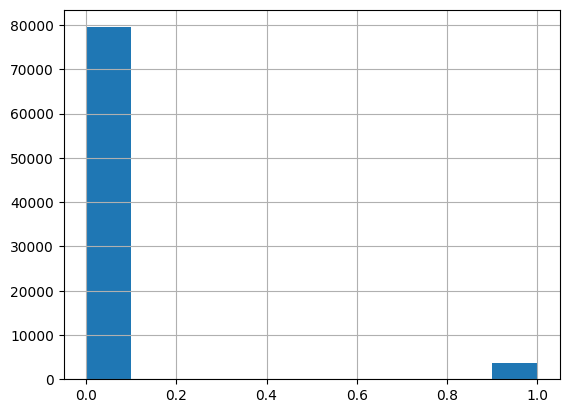

In [ ]:
df['Tipo_Mensaje'].hist()
### Como se puede observar el dataset esta desbalanceado

In [ ]:
# Preparacion de Datos
X = df["Mensaje"]
y = df["Tipo_Mensaje"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

vectorizador = TfidfVectorizer(
    stop_words=spanish_stop_words,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    lowercase=True
)

X_train_tfidf = vectorizador.fit_transform(X_train)
X_test_tfidf = vectorizador.transform(X_test)

### 2.1.2 Entrenamiento de Modelo

### Regresion Logistica

### Tratanto el Desbalanceo

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

log_reg = LogisticRegression(max_iter=1000,solver='saga',  class_weight='balanced')


## Ajuste de Hiperparametros
param_dist = {
    'C': loguniform(1e-4, 1e2),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_tfidf, y_train)

## Mejor Modelo
modelo = random_search.best_estimator_

print("Mejores hiperparámetros:")
print(random_search.best_params_)



Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Mejores hiperparámetros:
{'C': np.float64(36.30389268523312), 'l1_ratio': 0.75, 'penalty': 'l1'}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Evaluacion
from sklearn.metrics import classification_report, confusion_matrix

y_pred = modelo.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23852
           1       0.99      1.00      0.99      1098

    accuracy                           1.00     24950
   macro avg       1.00      1.00      1.00     24950
weighted avg       1.00      1.00      1.00     24950

[[23845     7]
 [    5  1093]]


### Sin Tratar el Desbalanceo

In [ ]:
# -----------------------------
# Sin tratar desbalance
# -----------------------------
log_reg = LogisticRegression(
    max_iter=1000,
    solver='saga'

)


param_dist = {
    'C': loguniform(1e-4, 1e2),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}


random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_tfidf, y_train)


modelo_sin_desbalanceo = random_search.best_estimator_

print("Mejores hiperparámetros:")
print(random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Mejores hiperparámetros:
{'C': np.float64(36.30389268523312), 'l1_ratio': 0.75, 'penalty': 'l1'}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Evaluacion
from sklearn.metrics import classification_report, confusion_matrix

y_pred = modelo_sin_desbalanceo .predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23852
           1       1.00      0.99      0.99      1098

    accuracy                           1.00     24950
   macro avg       1.00      1.00      1.00     24950
weighted avg       1.00      1.00      1.00     24950

[[23847     5]
 [    7  1091]]


### Palabras Asociadas a mensajes Tecnicos

In [ ]:
import numpy as np

feature_names = vectorizador.get_feature_names_out()
coeficientes = modelo.coef_[0]

top_palabras = sorted(
    zip(feature_names, coeficientes),
    key=lambda x: x[1],
    reverse=True
)[:100]

print("Palabras más asociadas a mensajes técnicos:")
for palabra, peso in top_palabras:
    print(palabra, round(peso, 3))

Palabras más asociadas a mensajes técnicos:
plantas 172.699
sustrato 134.125
planta 124.768
color 101.719
carnivoras 96.935
purpurea 77.7
hijuelos 76.394
hijuelo 69.043
sustratos 68.829
carnivora 66.671
plant 55.556
separar 48.215
purpura 44.907
purpureas 43.966
planeta 41.743
plantae 37.781
separa 34.806
plata 32.996
sutrato 28.154
humedad sustrato 25.765
plantan 22.879
plantea 22.015
tipo carnis 19.445
okefenokeensis 19.163
pudrieron 17.904
exportacion 16.879
leuco alba 13.703
aprovecha 12.634
carnivorous plant 11.99
emergencias 11.014
panel led 10.919
pack disponible 10.524
quieran 10.397
indoor rainbow 10.334
precio puedes 9.948
liquidas 9.929
dominar 9.325
vi pagina 9.182
prolongada 9.026
considerar 8.887
similares 8.727
inteligencia artificial 8.265
limon 8.225
ocupas 7.508
garden 7.05
rojizo purpura 6.864
caso 6.792
encuentra 6.332
with 6.236
packs disponibles 6.103
fungicidas 5.869
ngro 5.608
grow light 5.56
seres 5.49
sale mas 5.393
embargo importante 5.348
nm 5.235
votos opci

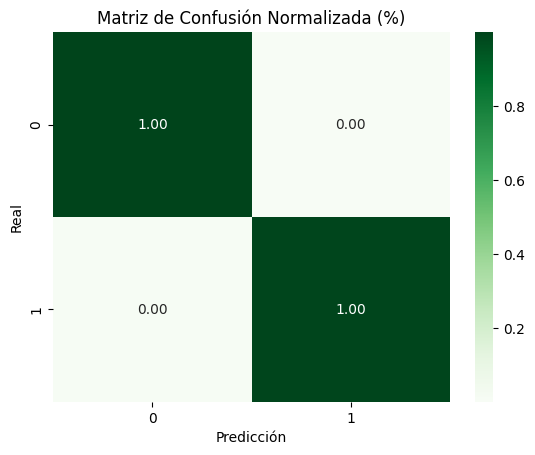

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión normalizada por fila
cm = confusion_matrix(y_test, y_pred, labels=modelo.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualización
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=modelo.classes_, yticklabels=modelo.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada (%)")
plt.show()

### Maquinas de Soporte Vectorial

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(
    class_weight='balanced',
    max_iter=2000
)

# Ajuste de Hiperparametro
param_dist = {
    'C': loguniform(1e-4, 1e2),
    'loss': ['hinge', 'squared_hinge']
}

random_search_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=40,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_svm.fit(X_train_tfidf, y_train)

# Mejor modelo
modelo_svm = random_search_svm.best_estimator_

print("Mejores hiperparámetros (SVM):")
print(random_search_svm.best_params_)

In [ ]:
### Evaluacion
y_pred = modelo.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

2.2 Modelo Variable Objetivo Continua

In [ ]:
ANCHOR_EXPERT = [
    "Nepenthes villosa es una especie de alta montaña que requiere noches frías, alta humedad y excelente oxigenación radicular",
    "El peristoma de Nepenthes funciona como una superficie resbaladiza cuando está húmedo, facilitando la captura de presas",
    "Las Nepenthes de tierras altas presentan metabolismo adaptado a temperaturas nocturnas bajas",
    "El sustrato mineral con buen drenaje reduce el riesgo de pudrición radicular en Nepenthes",
    "Sarracenia presenta rizomas subterráneos y requiere un periodo de dormancia invernal para un crecimiento saludable",
    "Las Sarracenia obtienen nutrientes principalmente de insectos atrapados en sus ascidios",
    "La falta de dormancia puede debilitar progresivamente a las Sarracenia",
    "Drosera captura presas mediante mucílago producido por tricomas glandulares",
    "La digestión en Drosera ocurre mediante enzimas secretadas sobre la presa atrapada",
    "Pinguicula presenta hojas con glándulas pegajosas que permiten la captura de pequeños insectos",
    "Algunas especies de Pinguicula desarrollan hojas no carnívoras durante la estación seca",
    "Los híbridos interespecíficos de Nepenthes pueden mostrar dominancia fenotípica del peristoma",
    "La identificación taxonómica de Nepenthes se basa en características como el peristoma, la tapa y el indumento",
    "Existen complejos de especies en Nepenthes que dificultan su clasificación taxonómica",
    "El exceso de humedad estancada favorece infecciones fúngicas en plantas carnívoras",
    "La ventilación constante es clave para evitar patógenos en cultivos de Nepenthes",
    "El uso de agua con baja conductividad es fundamental para el cultivo de plantas carnívoras",
    "Muchas plantas carnívoras habitan suelos pobres en nutrientes, lo que explica su estrategia carnívora",
    "La captura de insectos permite a las plantas carnívoras suplementar nitrógeno y fósforo"
]


In [ ]:
ANCHOR_CASUAL = [
    "qué bonita planta",
    "me gusta mucho esa planta",
    "se ve bien chula",
    "está preciosa",
    "me encantan las plantas",
    "esa planta está rara",
    "nunca había visto una así",
    "yo quiero una",
    "dónde la compraste",
    "estoy imprimiendo una pieza en 3D",
    "mi impresora 3D falló otra vez",
    "ya terminé de imprimir el soporte",
    "estoy diseñando una pieza en fusion 360",
    "esa pieza quedó perfecta en PLA",
    "voy a soldar unos cables",
    "el ventilador ya no prende",
    "tengo que cambiar el relay",
    "el controlador dejó de funcionar",
    "buenos días",
    "jajaja",
    "no inventes",
    "qué onda",
    "gracias"
]


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

embedder = SentenceTransformer("all-MiniLM-L6-v2")

expert_vec = embedder.encode(
    ANCHOR_EXPERT,
    normalize_embeddings=True
).mean(axis=0)

casual_vec = embedder.encode(
    ANCHOR_CASUAL,
    normalize_embeddings=True
).mean(axis=0)


In [ ]:
from numpy.linalg import norm

def specialization_score_embedding(text: str) -> float:
    if not isinstance(text, str) or text.strip() == "":
        return 0.0

    vec = embedder.encode(text, normalize_embeddings=True)

    sim_expert = np.dot(vec, expert_vec)
    sim_casual = np.dot(vec, casual_vec)

    score = (sim_expert - sim_casual + 1) / 2
    return round(np.clip(score, 0, 1), 3)


In [ ]:
df["especializacion"] = df["Mensaje"].apply(specialization_score_embedding)


In [ ]:
df

In [ ]:
df.to_csv("datos_etiquetados1.csv")

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Definir listas de referencia
ANCHOR_EXPERT = [
    "Nepenthes villosa es una especie de alta montaña que requiere noches frías, alta humedad y excelente oxigenación radicular",
    "El peristoma de Nepenthes funciona como una superficie resbaladiza cuando está húmedo, facilitando la captura de presas",
    "Las Nepenthes de tierras altas presentan metabolismo adaptado a temperaturas nocturnas bajas",
    "El sustrato mineral con buen drenaje reduce el riesgo de pudrición radicular en Nepenthes",
    "Sarracenia presenta rizomas subterráneos y requiere un periodo de dormancia invernal para un crecimiento saludable",
    "Las Sarracenia obtienen nutrientes principalmente de insectos atrapados en sus ascidios",
    "La falta de dormancia puede debilitar progresivamente a las Sarracenia",
    "Drosera captura presas mediante mucílago producido por tricomas glandulares",
    "La digestión en Drosera ocurre mediante enzimas secretadas sobre la presa atrapada",
    "Pinguicula presenta hojas con glándulas pegajosas que permiten la captura de pequeños insectos",
    "Algunas especies de Pinguicula desarrollan hojas no carnívoras durante la estación seca",
    "Los híbridos interespecíficos de Nepenthes pueden mostrar dominancia fenotípica del peristoma",
    "La identificación taxonómica de Nepenthes se basa en características como el peristoma, la tapa y el indumento",
    "Existen complejos de especies en Nepenthes que dificultan su clasificación taxonómica",
    "El exceso de humedad estancada favorece infecciones fúngicas en plantas carnívoras",
    "La ventilación constante es clave para evitar patógenos en cultivos de Nepenthes",
    "El uso de agua con baja conductividad es fundamental para el cultivo de plantas carnívoras",
    "Muchas plantas carnívoras habitan suelos pobres en nutrientes, lo que explica su estrategia carnívora",
    "La captura de insectos permite a las plantas carnívoras suplementar nitrógeno y fósforo"
]

ANCHOR_CASUAL = [
    "qué bonita planta",
    "me gusta mucho esa planta",
    "se ve bien chula",
    "está preciosa",
    "me encantan las plantas",
    "esa planta está rara",
    "nunca había visto una así",
    "yo quiero una",
    "dónde la compraste",
    "estoy imprimiendo una pieza en 3D",
    "mi impresora 3D falló otra vez",
    "ya terminé de imprimir el soporte",
    "estoy diseñando una pieza en fusion 360",
    "esa pieza quedó perfecta en PLA",
    "voy a soldar unos cables",
    "el ventilador ya no prende",
    "tengo que cambiar el relay",
    "el controlador dejó de funcionar",
    "buenos días",
    "jajaja",
    "no inventes",
    "qué onda",
    "gracias"
]

# Cargar modelo
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Vectores promedio de referencia
expert_vec = embedder.encode(ANCHOR_EXPERT, normalize_embeddings=True).mean(axis=0)
casual_vec = embedder.encode(ANCHOR_CASUAL, normalize_embeddings=True).mean(axis=0)

# Procesar todos los mensajes en lote
mensajes = df["Mensaje"].tolist()
embeddings = embedder.encode(mensajes, batch_size=32, show_progress_bar=True)

# Calcular puntajes continuos en lote
sim_expert = np.dot(embeddings, expert_vec)
sim_casual = np.dot(embeddings, casual_vec)
scores = (sim_expert - sim_casual + 1) / 2

# Guardar en el DataFrame con dos decimales
df["especializacion"] = np.clip(scores, 0, 1).round(2)

In [ ]:
df

In [ ]:
df.to_csv("Datos_Etiquetados.csv", index=False)